# Classification of skin cancer images using CNN

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['skin-cancer-mnist-ham10000', 'alexnetvisualization', 'alexnet']


## Import metadata, which contains the information of images and the corresponding cancer types

In [28]:
import pandas as pd 

df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [29]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

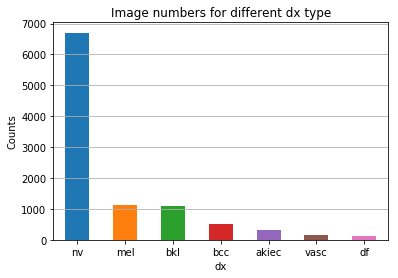

In [31]:
import matplotlib.pyplot as plt
#exp = pd.Series.to_frame(df1.groupby('dx').sex.value_counts())
df['dx'].value_counts().plot.bar(rot=0)
plt.title('Image numbers for different dx type')
plt.xlabel('dx')
plt.ylabel('Counts')
plt.grid(axis='y')

# 1. Create several more columns for the dataframe 'df'

1. Create 'num_images' to record the number of images belonging to the same 'lesion_id'
2. Create 'dx_id' convert the 'dx' to integer label
3. Create 'image_path' to store the path to access the image
4. Create 'images' to store the resized image as arrays

In [32]:
from os.path import isfile
from PIL import Image as pil_image
df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")

classes = df['dx'].unique()
labeldict = {}
for num, name in enumerate(classes):
    labeldict[name] = num
df['dx_id'] = df['dx'].map(lambda x: labeldict[x])


def expand_path(p):
    if isfile('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/' + p + '.jpg'): return '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/' + p + '.jpg'
    if isfile('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/' + p + '.jpg'): return '../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/' + p + '.jpg'
    return p 
df['image_path'] = df['image_id']
df['image_path'] = df['image_path'].apply(expand_path)


df['images'] = df['image_path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,112))))


# 2. show images

### show images belonging to the same lesion_id

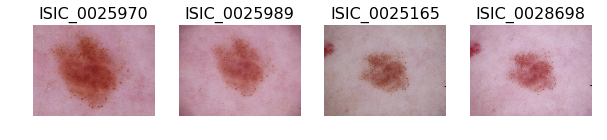

In [33]:
import matplotlib.pyplot as plt
        
def plot_images(imgs, labels, cols=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(10, 7))

    rows = len(imgs) // cols + 1

    for i in range(len(imgs)):
        img = plt.imread(expand_path(imgs[i]))
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(img, cmap='gray')        

images = df[df['lesion_id'] == 'HAM_0003033'].image_id

plot_images(list(images),list(images))

### show images belonging to the seven different types

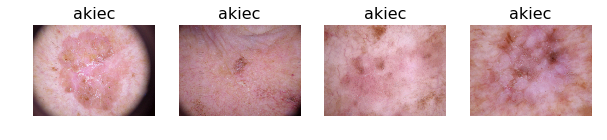

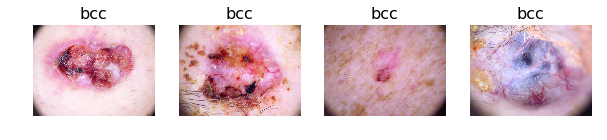

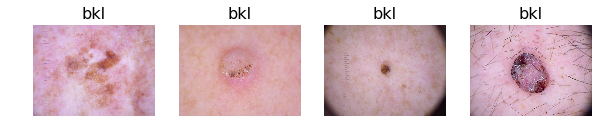

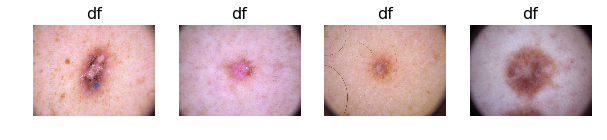

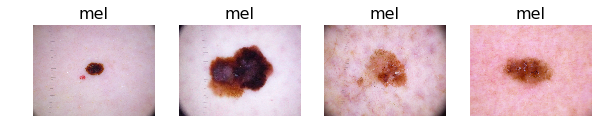

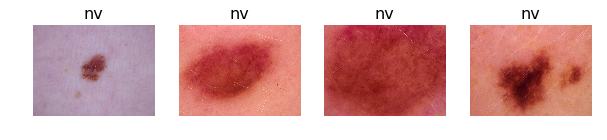

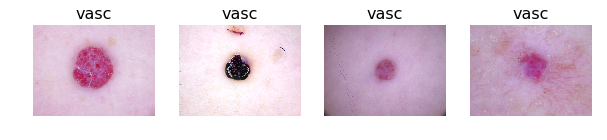

In [34]:
imgdict = {'akiec':list(df[df['dx']=='akiec']['image_id'])[0:24:6],'bcc':list(df[df['dx']=='bcc']['image_id'])[0:24:6],\
        'bkl':list(df[df['dx']=='bkl']['image_id'])[0:24:6],'df':list(df[df['dx']=='df']['image_id'])[0:24:6],\
        'mel':list(df[df['dx']=='mel']['image_id'])[0:24:6],'nv':list(df[df['dx']=='nv']['image_id'])[0:24:6],\
        'vasc':list(df[df['dx']=='vasc']['image_id'])[0:24:6]}
#print(imgdict,'\n',list(imgdict.values()),list(imgdict.keys()))
for i in np.arange(7):
    cancertype = list(imgdict.keys())[i]
    cancertypetolist = [cancertype,cancertype,cancertype,cancertype]
    plot_images(list(imgdict.values())[i],cancertypetolist)


# 3. Split the dataframe and create train, test and validation images and labels

select the testset and validationset from the lesion_id with only one corresponding image_id. It is reasonable to use such dataset in the test and validation step as these images have no similar sibling images

In [35]:
from sklearn.model_selection import train_test_split

df_single = df[df['num_images'] == 1]
trainset1, testset = train_test_split(df_single, test_size=0.2,random_state = 50)
trainset2, validationset = train_test_split(trainset1, test_size=0.2,random_state = 100)
trainset3 = df[df['num_images'] != 1]
frames = [trainset2, trainset3]
trainset = pd.concat(frames)

trainimages = np.asarray(list(trainset['images']/255))
testimages = np.asarray(list(testset['images']/255))
validationimages = np.asarray(list(validationset['images']/255))
trainlabels = np.asarray(trainset['dx_id'])
testlabels = np.asarray(testset['dx_id'])
validationlabels = np.asarray(validationset['dx_id'])


# 4. Data augmentation

### Since there are not too many images belonging to each skin cancer type, it is better to augment data before training. Data augmentation includes rotation, zoom, shift in two directions

In [36]:
from keras.preprocessing.image import ImageDataGenerator

trainimages = trainimages.reshape(trainimages.shape[0], *(112, 150, 3))

data_gen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1)  # randomly shift images vertically
#x = imageLoader(trainset,batch_size)
data_gen.fit(trainimages)

# 5. Build CNN model

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization

input_shape = (112, 150, 3)
num_labels = 7

# trainmodel includs four convolutional layers and three fully connected layers

trainmodel = Sequential()
trainmodel.add(Conv2D(32, (3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
#trainmodel.add(BatchNormalization())
trainmodel.add(MaxPool2D(pool_size = (2, 2)))
trainmodel.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
trainmodel.add(MaxPool2D(pool_size = (2, 2)))
trainmodel.add(Dropout(0.25))
trainmodel.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
trainmodel.add(MaxPool2D(pool_size = (2, 2)))
trainmodel.add(Conv2D(256, (3, 3), activation='relu',padding = 'Same'))
trainmodel.add(MaxPool2D(pool_size=(2, 2)))
trainmodel.add(Dropout(0.5))

trainmodel.add(Flatten())
trainmodel.add(Dense(504, activation='relu'))
trainmodel.add(Dropout(0.5))
trainmodel.add(Dense(63, activation='relu'))
trainmodel.add(Dense(num_labels, activation='softmax'))
trainmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 112, 150, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 37, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 37, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 18, 128)       0         
__________

In [ ]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.001)
trainmodel.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Fit the model
import keras

class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self,**kargs):
        super(CustomModelCheckPoint,self).__init__(**kargs)
        self.epoch_accuracy = {} # loss at given epoch
        self.epoch_loss = {} # accuracy at given epoch
        def on_epoch_begin(self,epoch, logs={}):
            # Things done on beginning of epoch. 
            return

        def on_epoch_end(self, epoch, logs={}):
            # things done on end of the epoch
            self.epoch_accuracy[epoch] = logs.get("acc")
            self.epoch_loss[epoch] = logs.get("loss")
            self.model.save_weights("name-of-model-%d.h5" %epoch)
            
checkpoint = CustomModelCheckPoint()

epochs = 30 
batch_size = 20
trainhistory = trainmodel.fit_generator(data_gen.flow(trainimages,trainlabels, batch_size=batch_size),
                              epochs = epochs, validation_data = (validationimages,validationlabels),
                              verbose = 1, steps_per_epoch=trainimages.shape[0] // batch_size,
                                       callbacks=[checkpoint])

# 6. Plot the accuracy and loss of both training and validation dataset

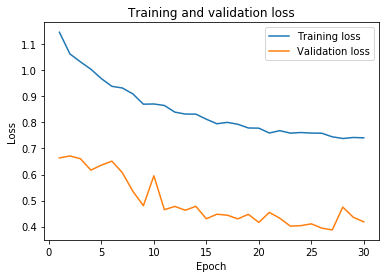

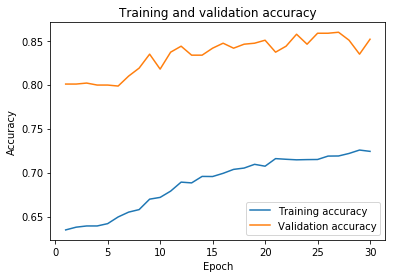

In [23]:
acc = trainhistory.history['acc']
val_acc = trainhistory.history['val_acc']
loss = trainhistory.history['loss']
val_loss = trainhistory.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '', label='Training accuracy')
plt.plot(epochs, val_acc, '', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [26]:
test_loss, test_acc = trainmodel.evaluate(testimages, testlabels, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

1103/1103 [==============================] - 10s 9ms/step
test_accuracy = 0.862194  ;  test_loss = 0.412697
